# Temporal Convolution Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm.auto import tqdm
import seaborn as sns
from dataclasses import dataclass
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preliminaries

### Loading Dataset

In [2]:
path = r'C:\Users\SUSHANT\Documents\ML_DL_Projects\Time Series Forecasting\datasets\jena_climate_2009_2016.csv'
df = pd.read_csv(path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### Fixing Datetime format

In [3]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index(df['Date Time'], inplace=True)
df = df.drop('Date Time', axis=1)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### Metadata

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


#### Fixing missing values

In [5]:
df['wv (m/s)'] = df['wv (m/s)'].replace(to_replace=-9999.0, value=0.0)
df['max. wv (m/s)'] = df['max. wv (m/s)'].replace(to_replace=-9999.0, value=0.0)
print(f'New min of wv : {df['wv (m/s)'].min()}\nNew min of max wv : {df['max. wv (m/s)'].min()}')

New min of wv : 0.0
New min of max wv : 0.0


### Preprocessing

#### Train and Test Split

*Important point:*
- Only a subset of features are used for simplicity.
- Hourly data for a year is taken for train and test split instead of per 10 mins measured in dataset.

In [6]:
features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
yearly_sample = 365.25 * 24 * 6


train_data = df[features][:int(yearly_sample * 2):6].to_numpy()
test_data = df[features][int(yearly_sample*2) : int(yearly_sample * 4):6].to_numpy()
print(f'Train Data Shape : {train_data.shape}\nTest Data shape : {test_data.shape}')

Train Data Shape : (17532, 3)
Test Data shape : (17532, 3)


##### Visualizing our splits

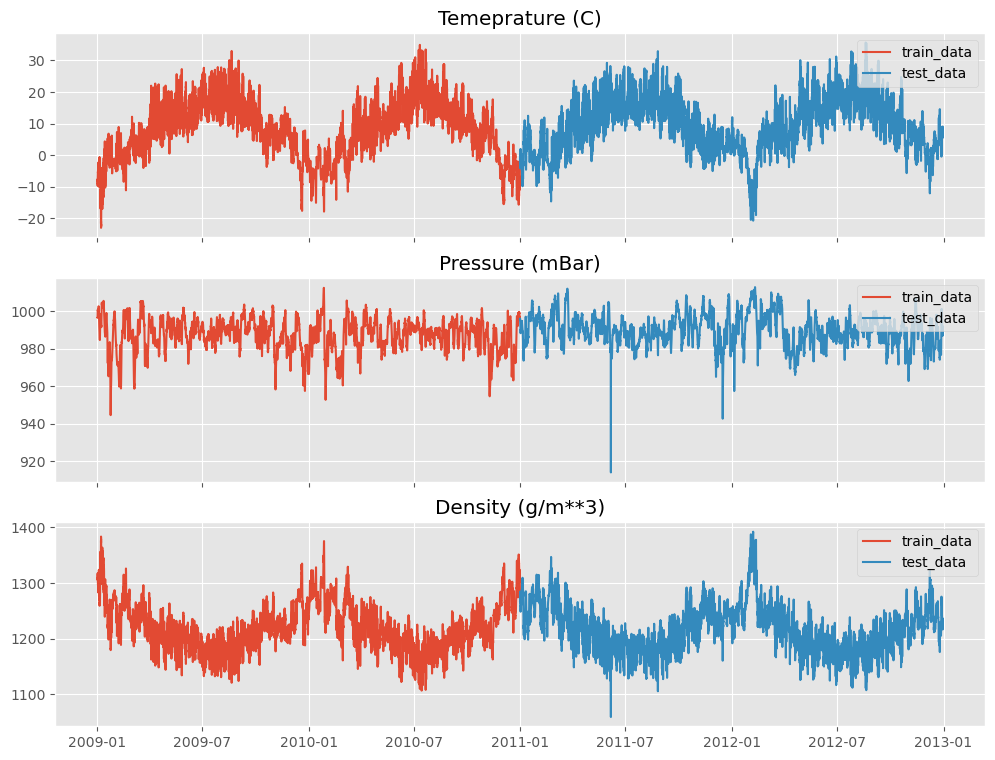

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)
titles = ['Temeprature (C)', 'Pressure (mBar)', 'Density (g/m**3)']

for i in range(3):
    axs[i].plot(df.index[:int(yearly_sample*2):6], train_data[:,i], label='train_data')
    axs[i].plot(df.index[int(yearly_sample*2):int(yearly_sample*4):6], test_data[:,i], label = 'test_data')
    axs[i].legend(loc="upper right")
    axs[i].set_title(titles[i])
plt.show()

#### Standard Scaler

In [8]:
class StandardScaler:
    def fit(self, x, axis):
        self.mean = np.mean(x, axis=axis)
        self.std = np.std(x, axis=axis)
    
    def transform(self, x):
        return (x - self.mean) / self.std

    def inverse_transform(self, x):
        return x * self.std + self.mean

In [9]:
scaler = StandardScaler()
scaler.fit(train_data, axis=0)
sc_data = scaler.transform(train_data)
print(f'Orignal Mean values of features : {scaler.mean}\nOrignal Standard deviation values of features : {scaler.std}')

Orignal Mean values of features : [   8.17252453  987.38820386 1219.70650867]
Orignal Standard deviation values of features : [ 9.03325185  8.52346058 41.73386411]


##### Visualizing Scaled Data

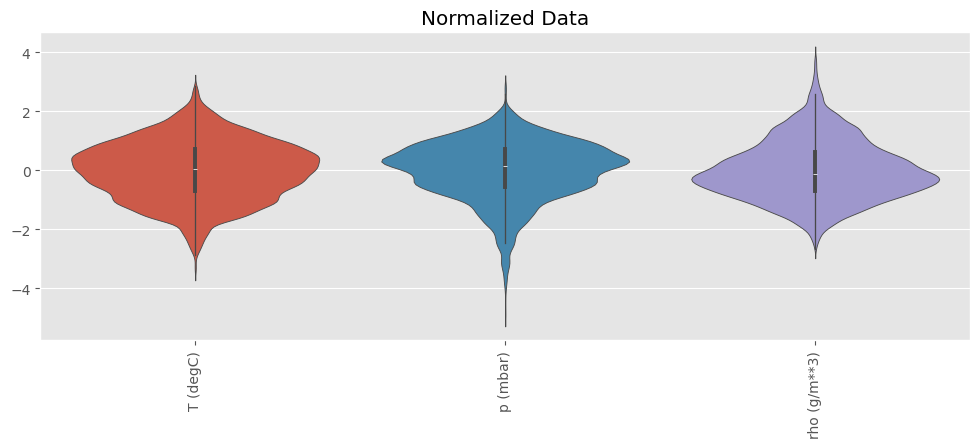

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (12, 4), sharex=True)

sns.violinplot(data=sc_data, ax=axs)
axs.xaxis.set_ticks(np.arange(0, train_data.shape[-1]))
axs.xaxis.set_ticklabels(features, rotation=90)
axs.set_title('Normalized Data')
plt.show();

### Dataset

<h4><u>Description</u><h4>
<ol>
<li><b> Input sequence length:</b> Length of input tensor.</li>
<li><b> Output sequence length:</b> Length of output tensor.</li>
<li><b> Ouffset:</b> Offset from starting position of input.</li>
</ol>

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data: np.ndarray, in_len: int, out_len: int, offset: int, in_feat: slice | int, out_feat: slice | int, scaler: StandardScaler):
        super().__init__()
        self.data = data
        self.in_len = in_len
        self.out_len = out_len
        self.offset = offset
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.scaler = scaler
        
        if self.in_len > self.offset + self.out_len:
            raise ValueError('Invalid input ouput mapping provided')
    
    def __len__(self):
        return len(self.data) - self.in_len - self.offset
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        in_len : starts from index
        offset : start from index
        out_len : starts from in_len + offset indice

        Args:
            index (int): index

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: input and label
        """
        data = self.data[index : index + self.in_len + self.offset]
        data = self.scaler.transform(data)
        x = torch.tensor(data[ : self.in_len, self.in_feat], dtype=torch.float32)
        y = torch.tensor(data[self.offset : self.offset + self.out_len, self.out_feat], dtype=torch.float32)
        
        # if in feats = 1
        if x.ndim == 1:
            x = x.view(-1, 1)    
        # if out feats = 1 
        if y.ndim == 1:
            y = y.view(-1, 1)
        return x, y
    
dataset = CustomDataset(data=train_data, in_len=24, out_len=24, offset=24, in_feat=0, out_feat=0, scaler=scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24, 1])
Label shape : torch.Size([24, 1])


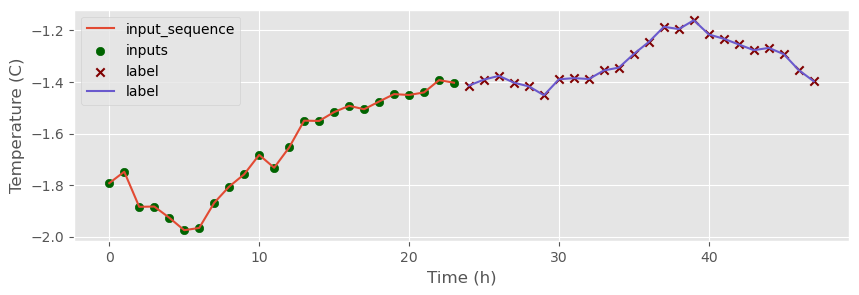

In [12]:
plt.figure(figsize=(10, 3))
plt.plot(range(0, 24), dataset[0][0].numpy(), label='input_sequence')
plt.scatter(range(0, 24), dataset[0][0].numpy(), label='inputs', color='darkgreen')
plt.scatter(range(24, 48), dataset[0][1].numpy(), color='maroon', label = 'label',marker='x')
plt.plot(range(24, 48), dataset[0][1].numpy(), color='slateblue', label = 'label')
plt.xlabel('Time (h)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show();

### Training Pipeline

In [13]:
class Trainer:
    def __init__(self, model, optimizer, dataset, batch_size, epochs):
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = next(self.model.parameters()).device
        
    def get_dataloader(self, split):
        train_dataset, val_dataset = random_split(self.dataset, [0.8, 0.2])
        if split == 'train':
            return DataLoader(train_dataset, self.batch_size, True, drop_last=True)
        elif split == 'val':
            return DataLoader(val_dataset, self.batch_size, False, drop_last=True)

    def train_model(self):
        loader = self.get_dataloader('train')
        total_loss = []
        self.model.train()
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = F.mse_loss(y, y_pred)
            loss.backward()
            self.optimizer.step()
            total_loss.append(loss.detach().cpu().numpy())
        return np.mean(total_loss)
    
    def eval_model(self):
        loader = self.get_dataloader('val')
        total_loss = []
        self.model.eval()
        for x, y in loader:         
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred = self.model(x)
                loss = F.mse_loss(y, y_pred)
                total_loss.append(loss.detach().cpu().numpy())     
        return np.mean(total_loss)
    
    def train(self):
        for epoch in tqdm(range(self.epochs)):      
            train_loss = self.train_model()
            val_loss = self.eval_model()
                
            if epoch % (self.epochs /10) == 0:
                gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                print(f'Epochs : {epoch} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f} | gpu usage : {gpu_usage}')

### Inference Pipeline

In [14]:
class Inference:
    def __init__(
        self, 
        model, 
        data, 
        scaler, 
        in_len, 
        out_len, 
        offset,
        in_feats, 
        out_feats, 
        prediction_style
        ):
        self.model = model
        self.data = data
        self.scaler = scaler
        self.in_len = in_len
        self.out_len = out_len
        self.offset = offset
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.prediction_style = prediction_style
        self.device = next(self.model.parameters()).device
    
    def get_random_sample(self):
        self.idx = np.random.randint(len(self.data) - self.in_len - self.offset)
        x = self.data[self.idx : self.idx + self.in_len, self.in_feats]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.float32, device = self.device)
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)        
        return x
    
    def ar_generation(self, x):
        for _ in range(self.out_len):
            x_trunc = x[:, -self.out_len:, :]
            y_pred = self.model(x_trunc)
            x = torch.cat((x_trunc, y_pred), dim=1)
        return x[:,-self.out_len:, :]
    
    def predict(self):
        x = self.get_random_sample()
        self.model.eval()
        with torch.inference_mode():
            if self.prediction_style == 'zs':
                y_pred = self.model(x)
            elif self.prediction_style == 'ar':
                y_pred = self.ar_generation(x)
        y_pred = self.scaler.inverse_transform(y_pred.cpu().detach().numpy())[:, :,self.out_feats]
        return y_pred.reshape(-1)
    
    def get_random_walk(self, initial, drift=0.0):
        noise = np.random.randn(self.out_len)
        noise = np.insert(noise, 0, initial)
        random_walk = np.cumsum(noise + drift, axis=0)
        return random_walk[1:]
    
    def calculate_rmse(self, y_pred, y):
        return np.mean((y - y_pred) ** 2)
    
    def plot(self, **title):
        y_pred = self.predict()
        x = self.data[self.idx : self.idx + self.in_len,self.out_feats]
        y = self.data[self.idx + self.in_len : self.idx + self.in_len + self.out_len, self.out_feats]
        plt.figure(figsize=(12, 5))
        
        print(f'rmse of predictions : {self.calculate_rmse(y_pred, y)}')
        print(f"rmse of baseline(previous day's temperature as preds): {self.calculate_rmse(x, y)}")       
        if len(x) == 1:
            plt.scatter(range(0, self.in_len), x, label='inputs', color='seagreen')
        else:
            plt.plot(range(0, self.in_len+1), self.data[self.idx : self.idx + self.in_len + 1,self.out_feats], color='seagreen', label='inputs')
            plt.plot(range(self.in_len, self.in_len+ self.out_len), y, label = 'true')
            plt.plot(range(self.in_len, self.in_len + self.out_len), x, color='goldenrod', label='baseline')
            plt.plot(range(self.in_len, self.in_len + self.out_len), y_pred, color='slateblue', label ='predictions')
            
        plt.scatter(range(self.in_len, self.in_len+ self.out_len), y, edgecolors='black')
        plt.scatter(range(self.in_len, self.in_len + self.out_len), x, marker='X', edgecolors='black', color='goldenrod')
        plt.scatter(range(self.in_len, self.in_len + self.out_len), y_pred, marker='X', edgecolors='black', color='slateblue')
        plt.legend()
        plt.xlabel('Time (h)')
        plt.ylabel('Temeprature (C)')
        
        title = title.get('title')
        if title is not None:
            plt.title(title)
        plt.show()

    def test_model(self, data, batch_size, in_feats, out_feats):
        dataset = CustomDataset(data, self.in_len, self.out_len, self.offset, in_feats, out_feats, self.scaler)
        dataloader = DataLoader(dataset, batch_size, drop_last=True)
        total_loss = []
        self.model.eval()
        with torch.inference_mode():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self.model(x)
                loss = F.mse_loss(y_pred, y)
                total_loss.append(loss.cpu().detach().numpy())
        return np.mean(total_loss)

## Model Design

### Causal Conv1d

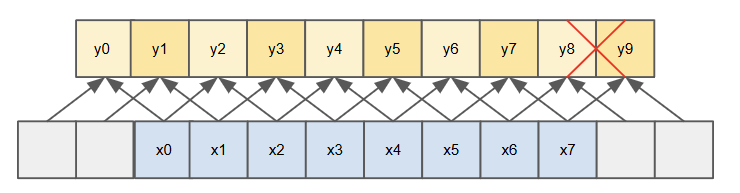

<b><u>Conv1D converted to CausalConv1D</u></b>:<br><br>
Observing carefully, we see that y2 depends only on x0 and x2, Similarly the rest of subsequent outputs do not depend on future terms, thus maintaining causality.

In [15]:
class CausalConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, dilation):
        super(CausalConv1d, self).__init__()
        padding = (kernel - 1) * dilation
        self.causal_conv = nn.Conv1d(in_ch, out_ch, kernel, stride, padding, dilation, bias=False)

    def forward(self, x):
        x = self.causal_conv(x)
        if self.causal_conv.padding[0] != 0:
            x = x[:, :, :-self.causal_conv.padding[0]]
        return x

<b>Note</b>:<br>
Minimum number of residual blocks <i>n</i> for full history coverage of input_length <i>l</i>  with kernel size <i>k</i> and with dilation base <i>b</i> is<br><br>
$n = ceil[log_b (\frac {(l-1)\cdot(b-1)}{(k-1)\cdot2} + 1)] $, 

In [ ]:
# For instance for kernel size of 2, 1 layer is required for complete receptive field coverage.
np.round(np.emath.logn(2, (3/2 + 1)))

np.float64(1.0)

### TCN Design

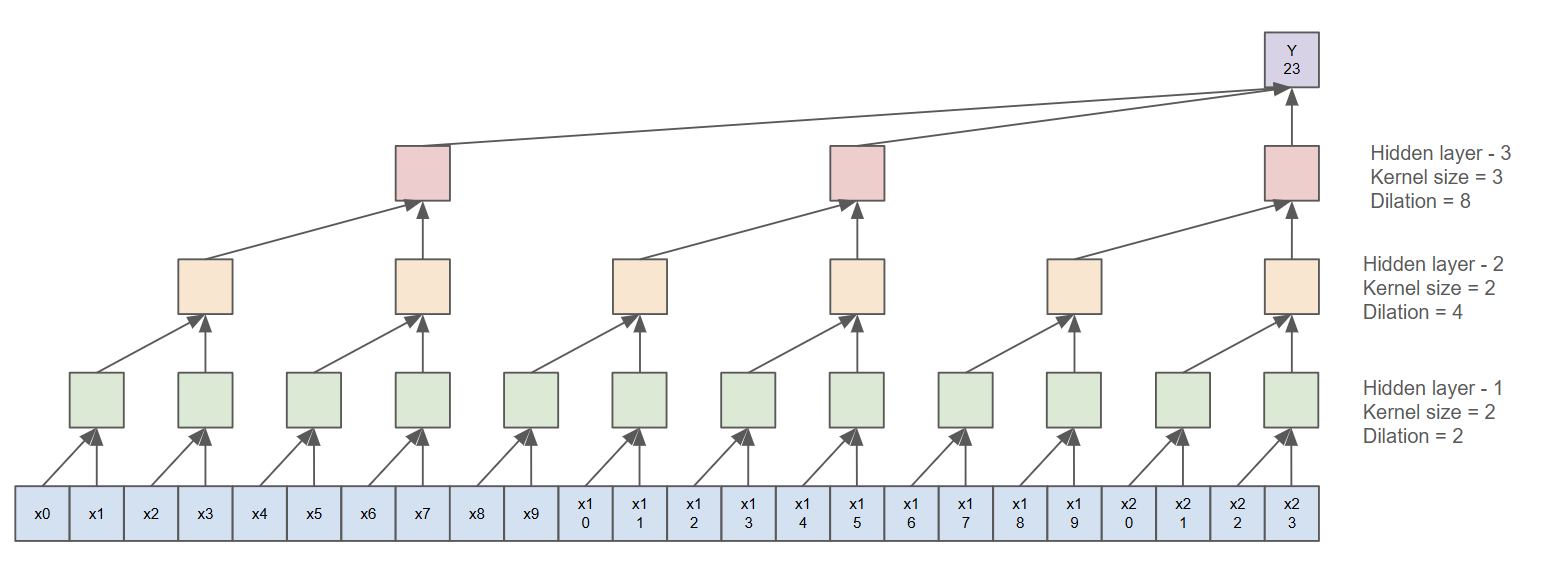

<b>Note:</b> Final Layer kernel size is changed to keep the final element have complete recpetive field coverage. This happend due to our sequence length being not a power or base dilation factor.

In [17]:
class TCN(nn.Module):
    def __init__(self, in_len, out_len, in_ch, out_ch, hid_ch, kernel, dilation, dropout):
        super(TCN, self).__init__()
        # initialisations
        self.nlayers = int(np.round(np.emath.logn(dilation, ((in_len-1)*(dilation-1)/((kernel - 1)*2)))))
        # Main forward pass layers
        self.init_conv = nn.Conv1d(in_ch, hid_ch, 1)
        self.res_blocks = nn.ModuleList()
        self.get_res_blocks(hid_ch, kernel, dilation, dropout)
        self.out_conv = nn.Conv1d(hid_ch, out_ch, 1)
        
        self.out_len = out_len
        
    def get_res_blocks(self, hid_ch, kernel, dilation, dropout):
        for l in range(self.nlayers-1):
            self.res_blocks.extend([
                CausalConv1d(hid_ch, hid_ch, kernel, stride=1, dilation=dilation**l),
                nn.BatchNorm1d(hid_ch),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        self.res_blocks.extend([
            CausalConv1d(hid_ch, hid_ch, 3, stride=1, dilation=8),
            nn.BatchNorm1d(hid_ch),
            nn.ReLU(),
            nn.Dropout(dropout)   
        ])
    
    def forward(self, x):
        
        x = self.init_conv(x.transpose(-1, -2))
        for block in self.res_blocks:
            x = block(x)
        x = self.out_conv(x).transpose(-1, -2)
        if self.out_len < x.shape[1]:
            x = x[:,-self.out_len,:]
        if x.ndim < 3:
            x = x.unsqueeze(1)
        return x
    
model = TCN(in_len=24, out_len=1, in_ch=1, out_ch=1, hid_ch=32, kernel=2, dilation=2, dropout=0.2)
x = torch.randn(1, 24, 1)
print(model(x).shape)

torch.Size([1, 1, 1])


In [18]:
print(f'Num Params: {sum(p.numel() for p in model.parameters())}')
model

Num Params: 9569


TCN(
  (init_conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (res_blocks): ModuleList(
    (0): CausalConv1d(
      (causal_conv): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
    )
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): CausalConv1d(
      (causal_conv): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
    )
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): CausalConv1d(
      (causal_conv): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
    )
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): CausalConv1d(
      (causal_conv): Conv1d(32, 32, kernel_size=(3,),

In [19]:
del model

### Zero Shot Training

`Note:` Intuitively it makes less sense since, only the last element of the last layer has complete recpetive field coverage and thus contain the entire relations between input elements, while elements moving to the left have less recpetive field coverage and thus less information.

In [20]:
@dataclass
class config:
    in_len = 24
    out_len = 24
    offset = 24
    in_feats = 3
    out_feats = 1
    hid_ch = 32
    kernel = 2
    dilation = 2
    dropout = 0.2

In [21]:
scaler = StandardScaler()
scaler.fit(train_data, axis=0)
dataset = CustomDataset(train_data, in_len=config.in_len, out_len=config.out_len, offset=config.offset, in_feat=slice(0, config.in_feats), out_feat=0, scaler=scaler)
print(f'Input Data shape : {dataset[0][0].shape}\nOutput Data shape : {dataset[0][1].shape}')

Input Data shape : torch.Size([24, 3])
Output Data shape : torch.Size([24, 1])


In [22]:
model = TCN(config.in_len, config.out_len, config.in_feats, config.out_feats, config.hid_ch, config.kernel, config.dilation, config.dropout)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [23]:
trainer = Trainer(model, optimizer, dataset, batch_size=512, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.5143 | val loss : 0.3294 | gpu usage : 0.0
Epochs : 1 | train loss : 0.2443 | val loss : 0.1516 | gpu usage : 0.0
Epochs : 2 | train loss : 0.2045 | val loss : 0.1458 | gpu usage : 0.0
Epochs : 3 | train loss : 0.1957 | val loss : 0.1378 | gpu usage : 0.0
Epochs : 4 | train loss : 0.1870 | val loss : 0.1326 | gpu usage : 0.0
Epochs : 5 | train loss : 0.1814 | val loss : 0.1332 | gpu usage : 0.0
Epochs : 6 | train loss : 0.1811 | val loss : 0.1328 | gpu usage : 0.0
Epochs : 7 | train loss : 0.1738 | val loss : 0.1286 | gpu usage : 0.0
Epochs : 8 | train loss : 0.1742 | val loss : 0.1337 | gpu usage : 0.0
Epochs : 9 | train loss : 0.1703 | val loss : 0.1304 | gpu usage : 0.0


#### Running Inference

rmse of predictions : 11.785171369284518
rmse of baseline(previous day's temperature as preds): 8.142445833333333


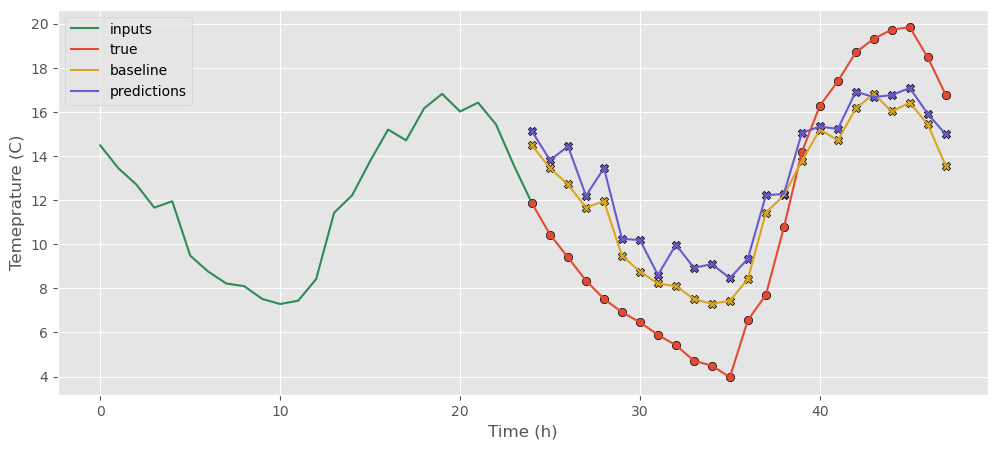

In [24]:
inference = Inference(model, test_data, scaler, config.in_len, config.out_len, config.offset, slice(0, config.in_feats), 0, 'zs')
inference.plot()

<b>Notes:</b>
<ul>
<li>If observed carefully model is predicting the last days values as our prediction. This is because, for majority days, the temeprature of <i>subsequent days follows the same patterns as previous day.</i></li>
<li>Other observation to be made is that, as discussed earlier conditioning whole output of our last layer leads to elements having more information as we move from beginning to end of the sequence. This leads to <i>initial predictions having larger errors.</i>
<br>
This seems to be true even with different kernel sizes.<br><br>
<b>To cross check wether if something might be wrong, we check our dataset values:</b>

In [25]:
print(
    f'Scaled Train Data for input + label len : \n{sc_data[:48,0]}',
    f'\n\nInput obatained from Dataset :\n{dataset[0][0][:,0]}',
     f'\n\nLabel obatained from Dataset :\n{dataset[0][1][:,0]}',
    )

Scaled Train Data for input + label len : 
[-1.79254656 -1.74826572 -1.88442931 -1.88332229 -1.92649611 -1.97520503
 -1.96634887 -1.86893101 -1.80583081 -1.75822891 -1.68295148 -1.73276742
 -1.65416893 -1.55010895 -1.55121597 -1.51689832 -1.49254385 -1.50582811
 -1.47593854 -1.44715599 -1.45047705 -1.44051386 -1.39291196 -1.40287515
 -1.41394536 -1.39069792 -1.37630664 -1.40287515 -1.41726642 -1.45158408
 -1.3895909  -1.38516281 -1.38848387 -1.35527324 -1.34420303 -1.29106602
 -1.24457114 -1.18589902 -1.19475519 -1.16043754 -1.21578859 -1.23239391
 -1.25453433 -1.27667475 -1.26781858 -1.29217304 -1.35416622 -1.39734004] 

Input obatained from Dataset :
tensor([-1.7925, -1.7483, -1.8844, -1.8833, -1.9265, -1.9752, -1.9663, -1.8689,
        -1.8058, -1.7582, -1.6830, -1.7328, -1.6542, -1.5501, -1.5512, -1.5169,
        -1.4925, -1.5058, -1.4759, -1.4472, -1.4505, -1.4405, -1.3929, -1.4029]) 

Label obatained from Dataset :
tensor([-1.4139, -1.3907, -1.3763, -1.4029, -1.4173, -1.4516, -1.

**This ensures that due to large number of subsequent days having similar values of temperature, trained models seems to be biased at predicting similar values as our input.**

In [26]:
del model

### AutoRegressive Training

`Note:` Intuitively it makes more sense to use the last element of the last layer as it has complete recpetive field coverage.

In [27]:
@dataclass
class config:
    in_len = 24
    out_len = 1
    offset = 24
    in_feats = 1
    out_feats = 1
    hid_ch = 32
    kernel = 2
    dilation = 2
    dropout = 0.2

In [28]:
scaler = StandardScaler()
scaler.fit(train_data[:, 0], axis=0)
dataset = CustomDataset(train_data, in_len=config.in_len, out_len=config.out_len, offset=config.offset, in_feat=slice(0, config.in_feats), out_feat=slice(0, config.out_feats), scaler=scaler)
print(f'Input Data shape : {dataset[0][0].shape}\nOutput Data shape : {dataset[0][1].shape}')

Input Data shape : torch.Size([24, 1])
Output Data shape : torch.Size([1, 1])


In [29]:
model = TCN(config.in_len, config.out_len, config.in_feats, config.out_feats, config.hid_ch, config.kernel, config.dilation, config.dropout)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [30]:
trainer = Trainer(model, optimizer, dataset, batch_size=512, epochs=10)
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 0 | train loss : 0.3388 | val loss : 0.2381 | gpu usage : 0.0
Epochs : 1 | train loss : 0.1349 | val loss : 0.0668 | gpu usage : 0.0
Epochs : 2 | train loss : 0.1021 | val loss : 0.0322 | gpu usage : 0.0
Epochs : 3 | train loss : 0.0882 | val loss : 0.0362 | gpu usage : 0.0
Epochs : 4 | train loss : 0.0783 | val loss : 0.0289 | gpu usage : 0.0
Epochs : 5 | train loss : 0.0733 | val loss : 0.0174 | gpu usage : 0.0
Epochs : 6 | train loss : 0.0705 | val loss : 0.0190 | gpu usage : 0.0
Epochs : 7 | train loss : 0.0672 | val loss : 0.0193 | gpu usage : 0.0
Epochs : 8 | train loss : 0.0627 | val loss : 0.0174 | gpu usage : 0.0
Epochs : 9 | train loss : 0.0618 | val loss : 0.0140 | gpu usage : 0.0


#### Inference

rmse of predictions : 46.45298968746499
rmse of baseline(previous day's temperature as preds): 2.6961041666666676


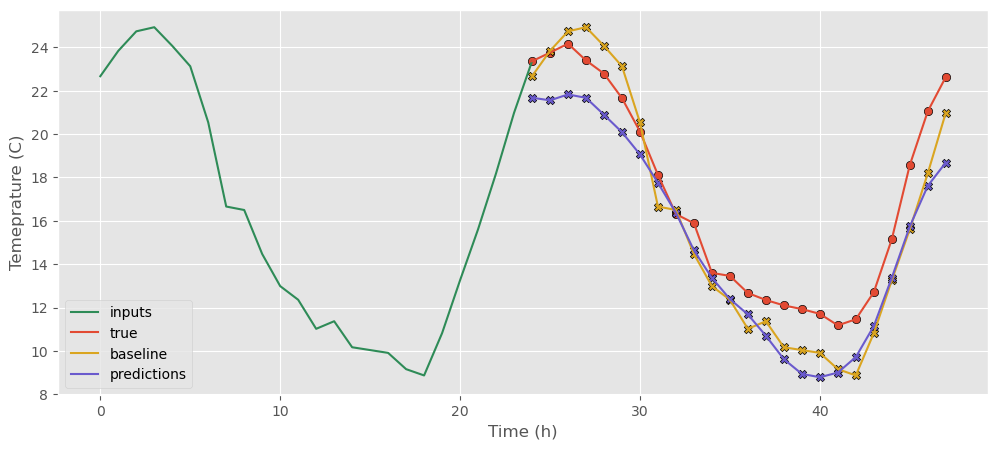

In [31]:
inference = Inference(model, test_data, scaler, config.in_len, 24, config.offset, slice(0, config.in_feats), slice(0, config.out_feats), 'ar')
inference.plot()

<b>Note</b>
<ul>
<li>Conditioning our last element of last layer as output leads to <i>less errors for initial predictions</i>. But since the prediction is autoregressive, the erros grows cumulatively for subsequent predictions</li>

In [32]:
del model

### Classification AutoRegressive

`Note:` The trainig here is univarite and should not be compared with the multi variate. To do multivarite in this method the tensor would have to flattened making,<br>
<b>new sequence length = orignal_seq_len x num_features<b>

In [33]:
@dataclass
class config:
    in_len =  24
    out_len = 24
    offset = 1
    vocab_size = 128
    hid_ch = 32
    kernel = 2
    dilation = 2
    dropout = 0.2

#### Scaler

In [34]:
class MinMaxScaler:
    def __init__(self, vocab_size:int):
        self.new_min = 0
        self.new_max = vocab_size - 1

    def fit(self, data:np.ndarray, axis:int):
        self.data_min  = np.min(data, axis=axis)
        self.data_max = np.max(data, axis=axis)

    def transform(self, data: np.ndarray) -> np.ndarray:
        data =  (data - self.data_min) / (self.data_max - self.data_min) * (self.new_max - self.new_min) + self.new_min
        return np.round(data).astype(np.int32)

    def inverse_transform(self, scaled_data: np.ndarray) -> np.ndarray:
        return (scaled_data - self.new_min) / (self.new_max - self.new_min) * (self.data_max - self.data_min) + self.data_min

#### Dataset

In [35]:
class CustomDataset(Dataset):
    def __init__(self, data: np.ndarray, in_len: int, out_len: int, offset: int, scaler: StandardScaler):
        super().__init__()
        self.data = data
        self.in_len = in_len
        self.out_len = out_len
        self.offset = offset
        self.scaler = scaler
        
        if self.in_len > self.offset + self.out_len:
            raise ValueError('Invalid input ouput mapping provided')
    
    def __len__(self):
        return len(self.data) - self.in_len - self.offset
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        in_len : starts from index
        offset : start from index
        out_len : starts from in_len + offset indice

        Args:
            index (int): index

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: input and label
        """
        data = self.data[index : index + self.in_len + self.offset]
        data = self.scaler.transform(data)
        x = torch.tensor(data[ : self.in_len], dtype=torch.long)
        y = torch.tensor(data[self.offset : self.offset + self.out_len], dtype=torch.long)
        return x, y
    
scaler = MinMaxScaler(vocab_size=128)
scaler.fit(train_data[:,0], axis=0)
dataset = CustomDataset(data=train_data[:,0], in_len=config.in_len, out_len=config.out_len, offset=config.offset, scaler=scaler)
print(f'Input shape : {dataset[0][0].shape}\nLabel shape : {dataset[0][1].shape}')

Input shape : torch.Size([24])
Label shape : torch.Size([24])


#### Model

In [36]:
class TCN(nn.Module):
    def __init__(self, vocab, in_len, out_len, hid_ch, kernel, dilation, blocks, dropout):
        super(TCN, self).__init__()
        # initialisations
        self.nlayers = int(np.round(np.emath.logn(dilation, ((in_len-1)*(dilation-1)/((kernel - 1)*2)))))
        self.blocks = blocks
        # Main forward pass layers
        self.embedding = nn.Embedding(vocab, hid_ch)
        self.res_blocks = nn.ModuleList()
        self.get_res_blocks(hid_ch, kernel, dilation, dropout)
        self.out = nn.Linear(hid_ch, vocab)
        
        self.out.weight = self.embedding.weight
        
        self.out_len = out_len
        
    def get_res_blocks(self, hid_ch, kernel, dilation, dropout):
        for _ in range(self.blocks):
            for l in range(self.nlayers-1):
                self.res_blocks.extend([
                    CausalConv1d(hid_ch, hid_ch, kernel, stride=1, dilation=dilation**l),
                    nn.BatchNorm1d(hid_ch),
                    nn.ReLU(),
                    nn.Dropout(dropout)
                ])
            self.res_blocks.extend([
                CausalConv1d(hid_ch, hid_ch, 3, stride=1, dilation=8),
                nn.BatchNorm1d(hid_ch),
                nn.ReLU(),
                nn.Dropout(dropout)   
            ])
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(-1, -2)
        for block in self.res_blocks:
            x = block(x)

        x = self.out(x.transpose(-1, -2))
        if self.out_len < x.shape[1]:
            x = x[:,-self.out_len,:]
        if x.ndim <3:
            x = x.unsqueeze(1)
        return x
    
model = TCN(vocab=128, in_len=config.in_len, out_len=config.out_len, hid_ch=config.hid_ch, kernel=config.kernel, dilation=config.dilation, blocks = 2, dropout=config.dropout)
x = torch.randint(0, 128, (1, 24))
print(model(x).shape)

torch.Size([1, 24, 128])


In [37]:
model.to(device)
print(f'num params : {sum(p.numel() for p in model.parameters())}')

num params : 23168


#### Trainer

In [38]:
def save_chkpt(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def load_chkpt(model, optimizer, path):
    device = next(model.parameters()).device
    chkpt = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(chkpt['model_state_dict'])
    optimizer.load_state_dict(chkpt['optimizer_state_dict'])
    return model, optimizer

In [39]:
class Trainer:
    def __init__(
            self,
            model: nn.Module,
            optimizer: torch.optim.Optimizer,
            dataset: Dataset,
            batch_size: int,
            epochs: int
            ):
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = next(self.model.parameters()).device

    def get_dataloader(self, split: str):
        train_dataset, val_dataset = random_split(self.dataset, [0.8, 0.2])
        if split == 'train':
            return DataLoader(train_dataset, self.batch_size, True, drop_last=True)
        elif split == 'val':
            return DataLoader(val_dataset, self.batch_size, False, drop_last=True)
        
    def evaluate_accuracy(self, y, y_pred):
        with torch.inference_mode():
            y_probs = F.softmax(y_pred, dim=-1)
            y_probs = torch.argmax(y_probs, dim=-1)
        return torch.mean((y == y_probs).float()).item()
    
    def train_model(self):
        loader = self.get_dataloader('train')
        loss_dict = {'loss': [], 'acc': []}
        self.model.train()
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
            loss.backward()
            self.optimizer.step()
            loss_dict['loss'].append(loss.cpu().item())
            loss_dict['acc'].append(self.evaluate_accuracy(y, y_pred))     
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def eval_model(self):
        loader = self.get_dataloader('val')
        loss_dict = {'loss': [], 'acc': []}
        self.model.eval()
        for x, y in loader:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                self.model.eval()
                y_pred = self.model(x)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                loss_dict['loss'].append(loss.cpu().item())
                loss_dict['acc'].append(self.evaluate_accuracy(y, y_pred))     
        return np.mean(loss_dict['loss']), np.mean(loss_dict['acc'])

    def train(self):
        for epoch in tqdm(range(self.epochs)):
            train_loss, train_acc = self.train_model()
            val_loss, val_acc = self.eval_model()

            if epoch % (self.epochs /10) == 0:
                gpu_usage = round(torch.cuda.memory_reserved(0)/1024**3,1)
                print(f'Epochs : {epoch} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f} |',
                      f'train_acc : {train_acc:.4f} | val_acc : {val_acc:.4f} | gpu usage : {gpu_usage}')

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [41]:
model, optimizer = load_chkpt(model, optimizer, 'models/temp_1.pt')

In [42]:

trainer = Trainer(model, optimizer, dataset, batch_size=512, epochs=50)
trainer.train()

  0%|          | 0/50 [00:00<?, ?it/s]

Epochs : 0 | train loss : 2.1961 | val loss : 1.9816 | train_acc : 0.2206 | val_acc : 0.2847 | gpu usage : 0.1
Epochs : 5 | train loss : 2.1932 | val loss : 1.9817 | train_acc : 0.2212 | val_acc : 0.2830 | gpu usage : 0.1
Epochs : 10 | train loss : 2.2005 | val loss : 1.9799 | train_acc : 0.2204 | val_acc : 0.2822 | gpu usage : 0.1
Epochs : 15 | train loss : 2.1978 | val loss : 1.9650 | train_acc : 0.2213 | val_acc : 0.2912 | gpu usage : 0.1
Epochs : 20 | train loss : 2.1885 | val loss : 1.9715 | train_acc : 0.2226 | val_acc : 0.2825 | gpu usage : 0.1
Epochs : 25 | train loss : 2.1894 | val loss : 1.9769 | train_acc : 0.2220 | val_acc : 0.2861 | gpu usage : 0.1
Epochs : 30 | train loss : 2.1903 | val loss : 1.9766 | train_acc : 0.2232 | val_acc : 0.2836 | gpu usage : 0.1
Epochs : 35 | train loss : 2.1914 | val loss : 1.9929 | train_acc : 0.2230 | val_acc : 0.2793 | gpu usage : 0.1
Epochs : 40 | train loss : 2.1799 | val loss : 1.9742 | train_acc : 0.2255 | val_acc : 0.2823 | gpu usage 

`Note`: It is difficult to train the model this way and is **not recommened**. The model accuracies plateu in most cases with different parameter choices.

In [43]:
save_chkpt(model, optimizer, 'models/temp_1.pt')

#### Inference

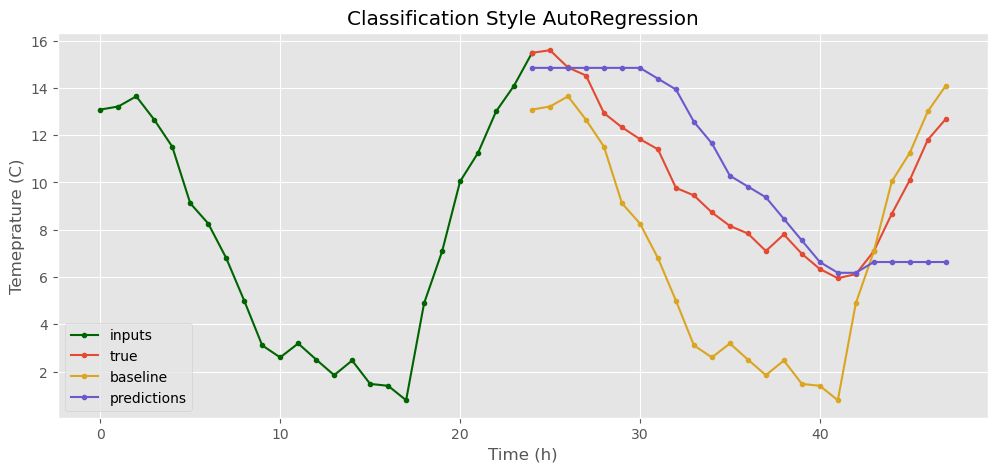

In [45]:
class Inference:
    def __init__(
        self,
        model: nn.Module,
        data: np.ndarray,
        scaler,
        input_width: int,
        label_width: int,
        offset: int,
        ):
        self.model = model
        self.data = data
        self.scaler = scaler
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset
        self.total_width = offset + label_width
        self.device = next(self.model.parameters()).device
        if self.total_width < self.input_width:
            raise ValueError('Input width should be less than label_width + offset.')

    def get_random_sample(self)->torch.Tensor:
        self.idx = np.random.randint(len(self.data) - self.total_width)
        x = self.data[self.idx : self.idx + self.input_width]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.long, device = self.device)
        if x.ndim == 1:
            x = x.view(1, -1)
        return x

    def ar_generation(self, x:torch.Tensor)->np.ndarray:
        self.model.eval()
        with torch.inference_mode():
            for _ in range(self.label_width):
                x_trunc = x[:, -self.label_width:]
                y_pred = self.model(x_trunc)
                y_pred = F.softmax(y_pred[:,-1,:], dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                x = torch.cat((x_trunc, y_pred.view(1,-1)), dim=1)
        return x[:,-self.label_width:].cpu().detach().numpy()


    def predict(self)->np.ndarray:
        x = self.get_random_sample()
        y_pred = self.ar_generation(x)
        y_pred = self.scaler.inverse_transform(y_pred).reshape(-1)
        return y_pred

    def plot(self):
        y_pred = self.predict()
        
        if self.offset < self.input_width:
            # For sliding window sequence generations.
            labels = self.data[self.idx + self.input_width : self.idx + self.input_width + self.label_width]
        else:
            # For no overlap between input and label predictions.
            labels = self.data[self.idx + self.offset : self.idx + self.offset + self.label_width]

        plt.figure(figsize=(12, 5))
        # inputs plot
        plt.plot(range(0, self.input_width + 1), self.data[self.idx : self.idx + self.input_width + 1], color='darkgreen', marker ='.', label='inputs')
        # true labels plot
        plt.plot(range(self.input_width, self.input_width + self.label_width), labels, marker = '.', label = 'true')
        # baseline -> last days value/ input as predication plots
        plt.plot(range(self.input_width, self.input_width + self.label_width), self.data[self.idx : self.idx + self.label_width], color='goldenrod', marker = '.', label='baseline')
        # predicted label plots
        plt.plot(range(self.input_width, self.input_width + self.label_width), y_pred, color='slateblue', marker = '.', label ='predictions')
        
        plt.legend()
        plt.xlabel('Time (h)')
        plt.ylabel('Temeprature (C)')
        plt.title('Classification Style AutoRegression')
        plt.show()

    def test_model(self, data:np.ndarray, batch_size:int)->np.ndarray:
        self.scaler.fit(data, axis=0)
        dataset = CustomDataset(data, self.input_width, self.label_width, self.offset, self.scaler)
        dataloader = DataLoader(dataset, batch_size, drop_last=True)
        total_loss = []
        hx = self.model._init_state(batch_size)
        self.model.eval()
        with torch.inference_mode():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                y_pred , hx = self.model(x, hx)
                loss = F.cross_entropy(y_pred.view(-1, y_pred.shape[-1]), y.view(-1))
                total_loss.append(loss.cpu().detach().numpy())
        return np.mean(total_loss)

inference = Inference(model, test_data[:,0], scaler, input_width=config.in_len, label_width=24, offset=config.offset)
inference.plot()

`Note:` 
- Training in this way is difficult and loss doesn't seem to converge.
- The straight line is due to the fact the TCN architecture does not have inductive bias and therefore assigns highest probability of the next token as the current token. 
- One of the possible reasons is due to the model not seeing such values enough times to learn anything.